# <div align="center"><i>Sustainability Is All You Need</i></div> 
***
**“Sustainability”** must be the most overused word in fashion and in the same vein, it’s the expression **“State-of-the-art”** in natural language processing. In the race for speed and performance, growth strategies of companies are sadly using a huge amount of resources. This research notebook will try to make a parallel between the importance of sustainability in fashion and the crucial role of reducing computing power in NLP. 

## Deep learning model “Whisper” from OpenAI in Japanese 
  * Quick introduction to **Audio Signal Processing** for NLP (Librosa and Fourier Transform) 
  * Earnings call  Q4 2022 - Group Senior Executive Officer & CFO of Fast Retail Group Co., Ltd, **Takeshi Okazaki** 
  * Earnings call  Q3 2022 - Senior Analyst & MD of Goldman Sachs Japan, **Sho Kawano**
  * Insights about **Whisper model** in Japanese and **strategy of Uniqlo** for Q4 2022

## Custom-made LDA model in Japanese with Gensim

  * Shareholder’s letters from 2010 to 2021 - Chairman, President & CEO of Fast Retailing Co., Ltd, **Tadashi Yanai**
  * Overview of **Fast Retailing Co's strategy** for the last 10 years

## <div align="center">Sustainability in fashion <br> アパレル業界におけるサステナビリティ</div>

The fashion industry is one of the biggest polluters in the world. The production cycles have accelerated over the years. Yet, fashion designers are often wrongfully compared to fast-fashion giants. Due to the volume of productions, fast-fashion brands should only be compared among themselves, H&M, Zara, Uniqlo, Shein, Forever 21, etc. 

I had the chance to visit many ateliers and factories around the world. And I strongly believe that **“Made by”** is more important than **“Made in”**. Fast Retailing’s supply chain is a fully integrated and clear overview of quality control at Uniqlo due to the strict Japanese management rules. On the opposite side, Zara has a strong supply chain with suppliers primarily in Spain/Portugal and the other half outside of Europe.  

The recommendation engine of the Chinese newcomer Shein, which feeds on macro trends of social media platforms will always have forecast bias. Often clients are coming for a fashionable item that they “like” on Instagram, but they will always buy more conservative clothes in shops. 

In my humble opinion, the most critical factor for sustainability is the **“number of wear”**. How many times should you wear an item of clothing before discarding it? A classic design from Uniqlo will probably be worn way more than a trendy item from H&M. 

## <div align="center">Climate change and Covid in Japan <br>  新型コロナウイルスと気候変動による日本へのインパクト</div>
Over the last 5 years, climate change and Sars-CoV-2 modified Japanese business practices and interactions. Promoted by the government of PM Koizumi in 2005, **“Cool biz”** encouraged a summer dress code in the government to reduce air conditioners and save energy. Nowadays, Cool Biz is becoming the life savior for salarymen in the private sector. Since 2015, Japanese high schoolers have been studying “**SDG**, Sustainable Development Goals” at school. And, **ESG investing** is booming in finance. 

One of Japan's buzzwords in 2020, the abbreviation **“DX”** short for digital transformation was a marketing term for top consulting firms, now it’s a reality for most companies. Video conference is now applied in large companies. 

And lucky for us, starting in 2021, Fast Retailing Group is recording quarterly earning calls with video streaming. We will do inference tests with Whisper of Open AI. : ) 
*** 

# <div align="center">ASR model "Whisper" of Open AI <br> OpenAI の音声認識モデル「Whisper」</div>

The unsupervised pre-training techniques for speech recognition in the Japanese language gave practitioners average results, sometimes very silly ones. In September 2022, OpenAI unveiled a full open-source model, **“Whisper”** in five sizes with a research paper entitled **“Robust Speech Recognition via Large-Scale Weak Supervision”**. The research team at OpenAI decided to use a supervised approach for their general-purpose speech recognition model. The weakly supervised speech recognition leverages around 680,000 hours of labeled audio data, and 117,000 hours to cover 96 other languages. As we will see, the model reveals incredible performance in transcriptions. 

Nothing new in NLP architecture, the model is based on a Transformer architecture (encoder-decoder) but the “robust speech processing” approach gave us interesting ideas. The signal processing used an "off-the shelves" architecture such as log-mel spectograms, two convolution layers, the GELU activation function, and sinusoidal positional encoding. The strong point of the model is the variety of datasets from Fleurs, Earnings 21/22 (earnings calls), VoxPopuli (European Parliament recordings), Switchboard, WSJ0/1 (Wall Street Journal), to LibriSpeech trained in zero-shot setting. This **“weakly” supervised model** gave us a good generalization for accents, background noise, and technical language. 

OpenAI researchers have used Python 3.9 and PyTorch for the AI framework (now part of Linux foundation top-level project). For fast tokenizers implementation, they leveraged the Transformers package of Hugging Face written in RUST. Audio files are processed in 30-second chunks by ffmpeg-python, which is transformed into log-Mel spectrograms.

In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import japanize_matplotlib
import seaborn as sns

import whisper
import ffmpeg

import librosa
import librosa.display
import IPython.display as ipd

from itertools import cycle
from IPython.display import Audio
%matplotlib inline 

## - Automatic Speech Recognition | 自動音声認識技術

In [2]:
CFO_FR_Okazaki = 'FR9983/ファーストリテイリング2022年8月期 第4四半期 決算説明会CFOの岡﨑.ogg'
y, sr = librosa.load(CFO_FR_Okazaki)
duration = librosa.get_duration(y=y, sr=sr)
print(f'Duration: {duration:.5f} seconds')

Duration: 28.88127 seconds


## - From speech to waveforms | 音声から波形へ

Speech is a series of sound waves made of air molecules created by the vibration of our vocal chords. The air pressure of over time changes, and is recorded by a microphone. **From time-domain to frequency-domain**, this signal made of discret data points will be become a digitized audio signal using Discrete Fourier Transform (DFT) with a sample rate per second and measured in Hertz. Waveform over time hold informations such as speed, amplitude, frequency, and period.

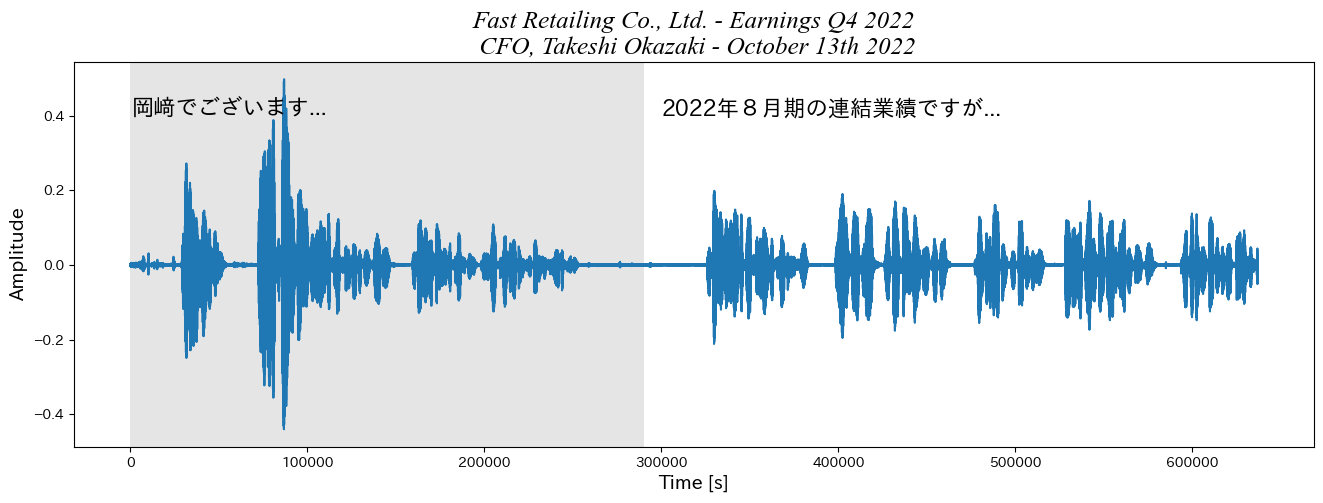

In [3]:
pd.Series(y).plot(figsize=(16,5))

plt.title("Fast Retailing Co., Ltd. - Earnings Q4 2022\n CFO, Takeshi Okazaki - October 13th 2022",fontsize=18,
          family='Times New Roman', style='italic')

plt.text(800, 0.4, '岡﨑でございます...', color='k', fontsize=16)
         
plt.axvspan(5, 290000,facecolor='0.5', alpha=0.2)

plt.text(300000, 0.4, '2022年８月期の連結業績ですが...', color='k', fontsize=16)

plt.xlabel("Time [s]", fontsize=14)
plt.ylabel("Amplitude", fontsize=14)

plt.show() 

## - From waveforms to log-mel spectograms | 時間波形からメルスペクトログラムへ

A spectrogram is a graphical representation of the sound in a time x frequency acoustic domain. In the deep learning architecture for ASR, Convolutional Neural Networks (CNN) is often used to isolate each character of the words in the speech. Whisper is leveraging "on-the-fly", resampling by ffmpeg (16kHz), Librosa for the 80-channel log magnitude Mel spectrogram representation (thx to the Short Time Fourier transform and Mel filter bank matrix), and the compute unified device architecture (CUDA) from Nvidia of 1D convolutional neural network from PyTorch. 

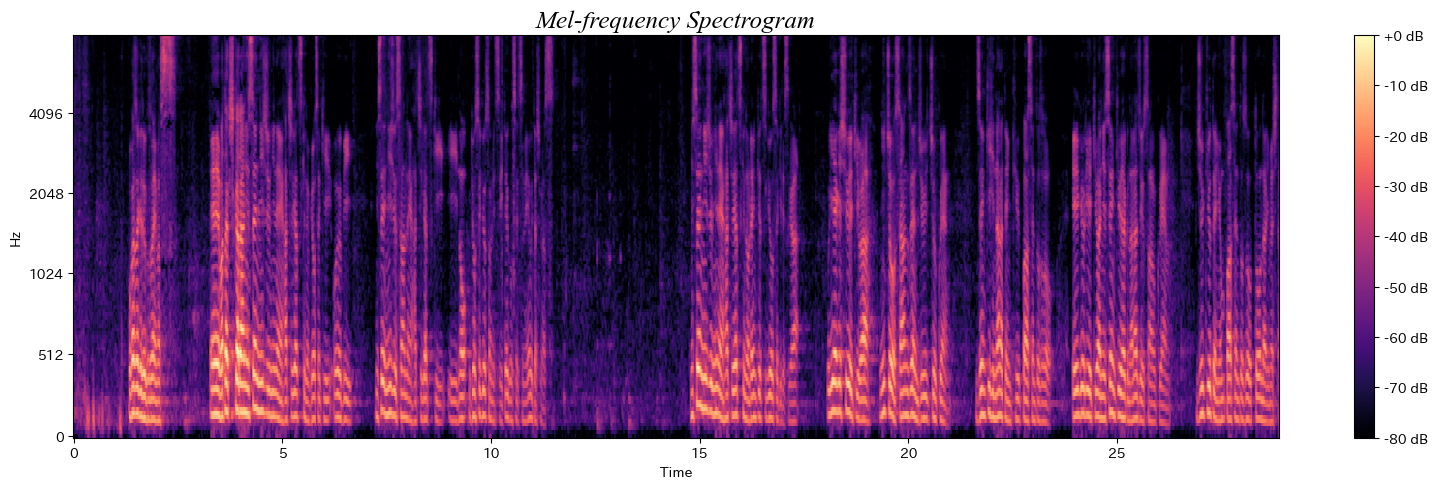

In [4]:
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000) #Mel-Spectogram 
S_dB = librosa.power_to_db(S, ref=np.max) #Quasi log-scaled 

fig, ax = plt.subplots(figsize=(16, 5))
img = librosa.display.specshow(S_dB, x_axis='time',y_axis='mel', sr=sr,fmax=8000, ax=ax) #Visualisation 
fig.colorbar(img, ax=ax, format='%+2.0f dB')
plt.title('Mel-frequency Spectrogram',fontsize=18,family='Times New Roman', style='italic')
plt.tight_layout()
plt.show() 

***
## <div align="center">Earnings announcement Q4 - 13th October 2022 <br> 2022年8月期 第4四半期 決算説明会 (2022年10月13日)</div>
***
- Fast Retailing Co,. Ltd. | CFO, **Takeshi Okazaki**
- 株式会社ファーストリテイリング | グループ上席執行役員CFO、**岡﨑健**

### <div align="center"><i>OpenAI Whisper - Base | 6 layers, 512 width, 8 heads, 74M parameters</i></div>

In [5]:
audio = whisper.load_audio("FR9983/FR2022年8月期 第4四半期 決算説明会CFOの岡﨑.mp3")
audio = whisper.pad_or_trim(audio)

base = whisper.load_model("base")
path = "FR9983/FR2022年8月期 第4四半期 決算説明会CFOの岡﨑.mp3"
result = base.transcribe(path, verbose=True, language='ja',fp16=False)

[00:00.000 --> 00:07.200] おかざけでございます 私から22年8月起の業績及び
[00:07.200 --> 00:11.600] 23年8月起の業績業層について ご説明をいたします
[00:11.600 --> 00:23.160] 22年8月起の連結業績ですが 上焼野州駅は2,311億円全規避7.9%
[00:23.160 --> 00:30.680] 当陸疫情排砲はとょでは Fire


* The base model gave us very poor results. The punctuation is not present. The dates are short and the numbers are wrong. 

### <div align="center"><i>OpenAI Whisper - Small | 12 layers, 768 width, 12 heads, 244M parameters</i></div>

In [6]:
small = whisper.load_model("small")
result1 = small.transcribe(path, verbose=True, language='ja',fp16=False)

[00:00.000 --> 00:12.000] おかざけでございます。私から2022年8月期の行籍及び、2023年8月期の行籍予想についてご説明をいたします。
[00:12.000 --> 00:29.000] 2022年8月期の連結業績ですが、売上収益は2兆3,011億円、前期比7.9%増、営業利益は2,973億円、19.4%増となりました。


* The small model delivers pretty good results. The first sentence gave us three mistakes, two in the complex accounting jargon such as “業績及び (concerning performance)” and “業績予想 (earnings forecast)” and one on the name of CFO “Okazake”. 


* The second sentence is perfect. The numbers and the dates are accurate. For ASR in Japanese, it’s extremely important to **normalize monetary signs** and numerical expressions into **Arabic numbers**. Financial vocabulary was perfectly found such as “売上収益 (sales revenues)”,  “前期比 (compared to the previous period)”, “営業利益 (Operating profit)”, and “19,4%増 (Increase of 19,4%)”.

### <div align="center"><i>OpenAI Whisper - Large | 32 layers, 1280 width, 20 heads, 1550M parameters</i></div>

In [7]:
large = whisper.load_model("large")
result2 = large.transcribe(path, verbose=True, language='ja',fp16=False)

[00:00.000 --> 00:03.000] 岡崎です。
[00:03.000 --> 00:14.000] 私から、2022年8月期の業績及び、2023年8月期の業績予想についてご説明をいたします。
[00:14.000 --> 00:30.000] 2022年8月期の連結業績ですが、売上金収益は2兆3,011億円、前期費7.9%増、営業利益は2,973億円、19.4%増となりました。


<i>**Official earnings call transcript**</i>: 
"CFOの岡﨑です。
私から、2022 年８月期の業績、および2023年８月期の業績予想について、ご説明いたします。
2022年８月期の連結業績ですが、売上収益は２兆 3,011 億円、前期比 7.9 ％増、営業利益は2,973 億円、同 19.4 ％増となりました。"

* The large model transcribes almost perfectly the first 30 seconds. The Whisper model did only a tiny mistake. The CFO Takeshi Okazaki is introducing himself by using **the honorific form “でごいざます (degozaimasu)”** to be polite toward shareholders. 

* But the Whisper model is changing into **the polite form “です (desu)”**, which is what the professional transcriber did on the transcription. Comparatively during the earning calls, President & CEO, Tadashi Yanai is introducing himself more relaxed, with the basic polite form “です (desu)”.

***
## <div align="center">Earnings announcement Q3 - 14th July 2022 <br> 2022年8月期 第3四半期 決算説明会 (2022年07月14日)</div>
***
- Goldman Sachs Securities | Managing Director, **Sho Kawano**
- ゴールドマン・サックス証券株式会社 | マネージング・ディレクター、**河野 祥** 

The sample of 30 seconds from CFO Takeshi Okazaki was mostly using **Japanese** and **Sino-Japanese words**. I will jump back in time to the Q3 2022 earnings call in order to bring complexity. In the beginning, the quality of the audio wasn't that good. The senior analyst of Goldman Sachs Japan asked a question about Chinese consumers and the reboot after the lockdown. This will be **a good test for Whisper on foreign words**. 


### <div align="center"><i>OpenAI Whisper - Small | 12 layers, 768 width, 12 heads, 244M parameters</i></div>

In [8]:
audio2 = whisper.load_audio("FR9983/FR2022年8月期 第3四半期 決算説明会Q1GSグレーター・チャイナ.mp3")
audio2 = whisper.pad_or_trim(audio2)

path2 = "FR9983/FR2022年8月期 第3四半期 決算説明会Q1GSグレーター・チャイナ.mp3"
result3 = small.transcribe(path2, verbose=True, language='ja',fp16=False)

[00:00.000 --> 00:04.000] よろしくお願いします。クオードマンサクスのおかわりです。
[00:04.000 --> 00:08.000] ちょっといろいろ質問あったんですけど、1点ということで、
[00:08.000 --> 00:16.000] グレータ・チャイナの非常に海外ユニクロ全体として国内ユニクロも非常に高調だったと思うんですけど、
[00:16.000 --> 00:25.000] グレータ・チャイナ、ここ1年ですね、苦戦してて、この後どうなるかという時にロックダウンになったので、
[00:25.000 --> 00:30.000] なかなか売上が回復してくるか、非常に見通し、


<i>**Official earnings call transcript**</i>: "Q グレーターチャイナ事業 の中長期の見方 を教えてください 。"

* During the Q&A, the senior analyst, Sho Kawano asked a question with many nuances. The transcriber summarized the question *"What is your medium to long-term outlook for the business in Greater China?"*. The company also hides the financial analyst's identity and the bank's name probably for legal reasons. 

* On the small model, the results are pretty good. Unfortunately, the most **important foreign word “Goldman Sachs” is wrongfully transcribed** in katakana “クオードマンサクス (Kuodoman Sachs)”. For automatic speech recognition of earnings calls, it’s important to transcribe perfectly for the named entity recognition model to recognize the business entity correctly. 

### <div align="center"><i>OpenAI Whisper - Large | 32 layers, 1280 width, 20 heads, 1550M parameters</i></div>

In [9]:
result4 = large.transcribe(path2, verbose=True, language='ja',fp16=False)

[00:00.000 --> 00:04.000] よろしくお願いします。 ゴールドマンサックスの岡原です。
[00:04.000 --> 00:08.000] ちょっといろいろ質問あったんですけど、一点ということで、
[00:08.000 --> 00:16.000] Greater Chinaの非常に海外ユニクロ全体として、 国内ユニクロも非常に好調だったと思うんですけど、
[00:16.000 --> 00:21.000] Greater China、ここ1年苦戦してて、
[00:21.000 --> 00:25.000] この後どうなるかというときにロックダウンになったので、
[00:25.000 --> 00:30.000] なかなか売上が回復してくるか、非常に見通している。


* Once again, the large model gave us an almost perfect transcription. The only error comes from the name of the senior analyst, **Sho Kawano** in Japanese 河野 祥（かわの・しょう), not **岡原** which can be commonly read as **Okahara**, **Okabara**, or **Okaharu**. This problem could be solved by training a bespoke Whisper model with board members of companies and financial analysts covering the Japanese stock exchange.  


* Goldman Sachs was accurately transcribed (ゴールドマンサックス). A strange phenomenon, the large model decided that “Greater China” should be written in romaji. In business settings, Greater China is normally in katakana “グレーターチャイナ” to describe the economic zone of China.

## Whisper in the finance industry | 金融業界で進むAI Whisper活用

Under an MIT license, this Whisper model by OpenAI will probably become a must for transcription. This open-source model could pose problems to various A.I start-ups, and diminish revenues for paid products such as Google Cloud Speech-to-Text and AWS Transcribe. 

Hopefully, the **supervised “weakly” approach** with various datasets will become a new norm for multilingual models. According to the paper, the increase in parameters will not really improve the accuracy. That insight will hopefully lead to more research on optimization for computing power and less on data-hungry NLP models. 

Whisper models seem to have better performance than the Conformer-CTC models of ***Nvidia***. The inference runtimes and computational requirements of Whisper might be a little bit heavy for the CPU. **Dynamic quantization** seems to be already a great solution for higher speedups and throughput. Another option will be to leverage the **sparsity** of neural networks to accelerate computing. 

I believed that **Whisper could be a defacto tool for earning calls in equity research**. With a full transcribe, foreign analysts will not have to wait for the corporate transcribe and English translation (from 3 or 7 days), nor lose insights from Q&A exchanges between local analysts and executives of listed companies.

## Insights of earning announcements | 決算説明会から読み取るインサイト

For earnings of Q3 2022, Tadashi Yanai gave the leading role to the North-American market. For Q4 2022, the CEO Europe of Fast Retailing, Taku Morikawa did a pretty insightful breakdown of operations in Europe. He explained the opening of flagship stores in major cities such as Stockholm, Milan, Copenhagen, and Madrid, but also new complementary stores in Paris on Rivoli street, London on Regent Street, and even a pop-up store in Poland. Taku Morikawa clearly separated the brand positioning of Zara and others. He pictured Uniqlo as a strong brand with a real identity for basics of quality at low prices. 

**Fast Retailing will appoint CEOs and COOs** for Uniqlo in various European countries who all came from a **retail background**. The global headquarters located in New York will have less impact with priority given to the CEOs and COOs of European countries. 
As President & CEO, Tadashi Yanai underlined the empowerment of talented management at Uniqlo in the retail business and described the world with the business expression in English **<i>“Global is local. Local is global”</i>**.

Unfortunately by cross-referencing LinkedIn, most CEOs and COO roles in Europe are occupied by Japanese executives coming from headquarters due probably to cultural or language barriers. Former Uniqlo's chief executive for Europe, Dr. Berndt Hauptkorn left Fast Retailing just after 3 years for Chanel.

***
# <div align="center">Latent Dirichlet Allocation <br> 潜在的ディリクレ配分法 </div>
***
- Fast Retailing Co,. Ltd. | Chairman, President & CEO, **Tadashi Yanai**
- 株式会社ファーストリテイリング | 代表取締役会長兼社長、**柳井正**

During my research, I found many great strategy insights about Fast Retailing by using LDA modeling on the annual shareholder letters of the founder **Tadashi Yanai** from 2010 to 2021 both in English and in Japanese. LDA (Latent Dirichlet Allocation) model is nothing new but delivers excellent results. LDA is a generative model for informational retrival in text data. It's often explained with a graphical interpretation. 

Even easier for an NLP approach, the probability of a document could be calculate as: 

$$ P(W,Z,\theta,\varphi,\alpha,\beta ) = \prod_{i=1}^{K} P(\varphi_i;\beta) \prod_{j=1}^{M} P(\theta_j;\alpha)  \prod_{t=1}^{N} P(Z_j,_t | \theta_j) P(W_j,_t | \varphi_{z_j,_t})$$

As the product of two Dirichlet distributions for **words** as $\prod_{i=1}^{K} P(\varphi_i;\beta)$ and for **topics** as $ \prod_{j=1}^{M} P(\theta_j;\alpha) $ 


And the product of two Multinomial distributions for **topics** and **words** as $ \prod_{t=1}^{N} P(Z_j,_t | \theta_j) P(W_j,_t | \varphi_{z_j,_t})$

<div align="center"><b><i>In order to keep the notebook in a short size, I will only reveal the insights.</b></i></div>

If Whisper of OpenAI is a great end-to-end solution, an LDA requires human output. For the Japanese language, I am using either Gensim (MeCab-Unidic) or sometimes Scikit-Learn (with SudachiPy), plus pyLDAvis for visualization. For the English language, Top2Vec is the perfect algorithm for semantic search. It leverages BERT (transformers architecture), plus decreases the dimension of embedding with UMAP (Uniform Manifold Approximation and Projection), and searches for the densest areas with HDBSCAN (Hierarchical Density-Based Spatial Clustering). 

LDA analysis revealed keywords and the structure of the shareholder’s letter in three distinctive parts.

* First part - **Insights about new collections** such as Heat-Teach and Christophe Lemaire
* Second part - **Retail expansions** with the names of capitals such as Paris, New York, and Shanghai
* Third part - Unusual events and **Strategy roadmap**


In a decade, the founder of Uniqlo expands the fast-fashion brand to become a more conscious label with the **"LifeWear"** philosophy. 

* In 2010, Tadashi Yanai explained the **consolidation** of Fast Retailing Group with brands such as Uniqlo, Theory, Comptoir des Cotonniers, et Princesse Tam Tam. 
* In 2011, the Japanese CEO positioned Uniqlo as **the world leader in fashion**.
* In 2012, he explained the concept of **Bikuro** (ビックロ) portmanteau word made of “Bic” and “Uniqlo” a huge store opened in partnership with Bic Camera (ビックカメラ). 
* In 2013, Tadashi Yanai installed the philosophy of **"LifeWear"** written in English where Uniqlo clothing is part of everyday life. 
* In 2014, the CEO relaunched his "**Global One**, グローバルワン" strategy dating from 2008, which aims to develop marketing, communication, a visual identity, and a unique strategy in the world.
* In 2015, in addition to the “Global One”, the management principle “**Zenin Keiei** (Zenin Keiei 全員経営)” emphasizes decision-making at all levels. 
* In 2016, the Japanese giant **digitized its supply chain**. 
* In 2017, the LifeWear philosophy becomes clothing **for sustainable development**.
* In 2018, Fast Retailing wants to be a more digital company with the **Ariake Project strategy** (有明プロジェクト). 
* In 2019, the CEO reaffirms the values of **"LifeWear"** for the creation of a garment. 
* In 2020, **Covid** affected the Japanese giant with the closure of stores around the world. 
* And In 2021, Tadashi Yanai completely equates **"LifeWear with Sustainability"**.

## From CSR to Sustainability | CSR 活動からサステナビリティまで

10 years ago, the founder was writing one quick sentence about “**CSR, Corporate Social Responsibility** (CSR 活動)” projects in Bangladesh. Today, the word “**Sustainability** (サステナビリティ)” became extremely important for the fashion industry and investors. 

In the earnings report of 2010, the chapter on CSR could be found at the end, on page 54. In the earnings report of 2021, sustainable pages are located on page 21. Nowadays, the Japanese fashion giant is even writing a separate report on sustainability. 

The Japanese group smartly separates their main business of quality basics with high volumes from the capsule collections of fashion designers such as **Christophe Lemaire, Jill Sanders, Marni**, and **JW Anderson**, or even Uniqlo's sister brand **GU** which is hugely popular in Japan, and in Asia. 

More than words, the **‘LifeWear’** strategy at the heart of Uniqlo for more than 10 years is more sustainable than European rivals. Fashion brands are not built with a few sparks of creativity in a short-term approach but rather over the long term with a stable creative vision. Two sons of Tadashi Yanai are seating on the board of members and the Yanai family owns the majority of shareholders. 

Will the successor continue to progress toward a more sustainable brand?

Thank you for reading!

Please feel free to contact me if you have any questions.

Akim Mousterou

***

**Disclaimer**: *None of the content published on this notebook constitutes a recommendation that any particular security, portfolio of securities, transaction, or investment strategy is suitable for any specific person. None of the information providers or their affiliates will advise you personally concerning the nature, potential, value, or suitability of any particular security, portfolio of securities, transaction, investment strategy, or other matter.*